# 9.1 Working with Sequences

Up until now, we have focused on models whose inputs consisted of a single feature vector $ \mathbb{x}  \in \mathbb{R}^d$. Tha main change of perspective when developing models capable of processing sequences is that we now focus on inputs that consist of an ordered list of feature vectors $\mathbb{x}_1, \mathbb{x}_2, ..., \mathbb{x}_T$, where each feature vector $\mathbb{x}_t$ is indexed by a time step $t \in \mathbb{Z}^{+}$ lying in $\mathbb{R}^d$.

## 9.1.1 Autoregressive Models

Before introducing specialized neural networks designed to handle sequentially structured data, let’s take a look at some actual sequence data and build up some basic intuitions and statistical tools. In particular, we will focus on stock price data from the FTSE 100 index. At each time step $ t \in \mathbb{Z} $, we observe the price, $x_t$, of the index at that time.

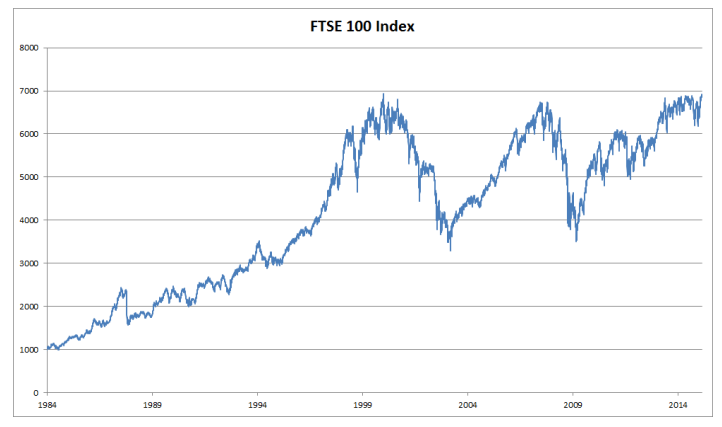

Now suppose that a trader would like to make short-term trades, strategically getting into or out of the index, depending on whether they believe that it will rise or decline in the subsequent time step. Absent any other features, the only available signal for predicting the subsequent value is the history prices to date. The trader is thus interested in knowing the probability distribution

$$
P(x_t| x_{t-1}, ..., x_1)
$$

over prices that the index might take in the subsequent time step. While estimating the entire distribuiton over a continuously valued random variable can be difficult, the trader would happy to focus on a few key statistics of the distribution, particularly the expected value and the variance. One simple strategly for estimating the conditional expectation

$$
\mathbb{E}[x_t|x_{t-1}, ..., x_1]
$$

would be to apply linear regression model. Such models that regress the value of a signal on the previous values of that same signal are naturally called autoregressive models. There is just one major problem: the number of inputs varies, depending on $t$.

Much of what follows in this chapter will revolve around techniques for overcoming theses challenges when engaging in such autoregressive modeling problems where the object of interest is $P(x_t|x_{t-1}, ..., x_1)$ or some statistics of this distribution.



A few strategies recur frequently. First of all, we might believe that altough long sequences are available, it may not be necessary to look back so far in the history when predicting the near future. In this case we might content ourselves to condition on some window of length $\tau$ and only use $\tau$ recent observations. The immediate benefit is that now the number of arguments is always the same, at least for $t > \tau$. This allow us to train any linear model or deep network that requires fixed-length vectors as inputs.

Second, we might develop models that maintain some summary $h_t$ of the past observations and at the same time update $h_t$ in addition to the predction $\hat{x_t}$. This leads to models that estimate not only $x_t$ with $\hat{x_t} = P(x_t | h_t) $ but also updates of the form $h_t = g(h_{t-1}, x_{t-1})$. Since $h_t$ is never observed, these models are also called autoregressive models.

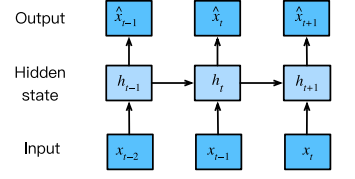

## 9.1.2 Sequence 

Language models (or sequence models): Estimated functions for sequence data.

While language modeling might not, at first glance, look like an autoregressive problem, we can reduce language modeling to autoregressive prediction by decomposing the joint density of a sequence $p(x_1, ..., x_T)$ into the product of conditional densities in a left-to-right fashion by applying the chain rule of probability:

$$
P(x_1, ..., x_T) = P(x_1) \Pi_{t=2}^T P(x_t|x_{t-1}, ..., x_1)
$$


Note: If we are working with discrete signals such as words, then the autoregressive model must be a probabilistic classifier, outputting a full probability distribution over the vocabulary for whatever word will come next, given the leftwards context.

### Markov Models

We say that the sequence satisfies a Markov condition, i.e., that the future is conditionally independent of the past, given the recent history. When τ = 1, we say that the data is characterized by a first-order Markov model, and when τ = k, we say that the data is characterized by a k th-order Markov model.

## 9.1.3 Training

Before we focus our attention on text data, let's first try this out with some continuous-valued synthetic data.

Here, our 1000 synthetic data will follow the trigonometric sin function, applied to 0.01 times the time step. To make the problem a little more interesting, we corrupt each sample with additive noise. From this sequence we extract training examples, each consisting of features and a label.

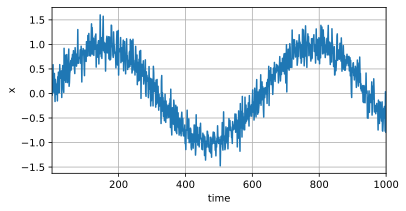

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T+1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + 0.2 * torch.randn(T)

data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

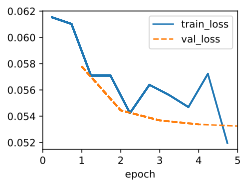

In [3]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

## 9.1.4 Prediction

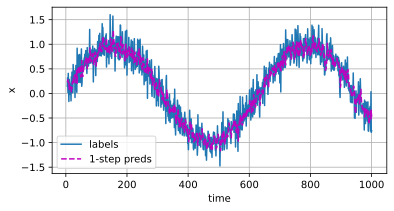

In [4]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x', legend=['labels', '1-step preds'], figsize=(6, 3))

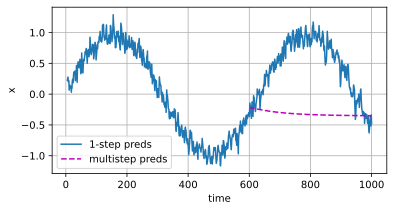

In [5]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]], [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time', 'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

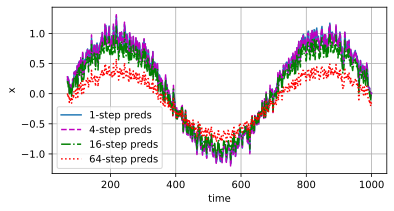

In [7]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
    [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
    legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))